# Bertelsmann Transformation Index (BTI)

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("BTI.csv").convert_dtypes()

### Rows and columns

In [5]:
rows, columns = df.shape
print(f"Rows: {rows}, Columns: {columns}")

Rows: 58725, Columns: 14


In [6]:
df['date'] = pd.to_datetime(df['yearmon'], errors='coerce')
df = df.convert_dtypes()
df = df.set_index(['date']).sort_index()
df = df.drop(columns=['yearmon'])

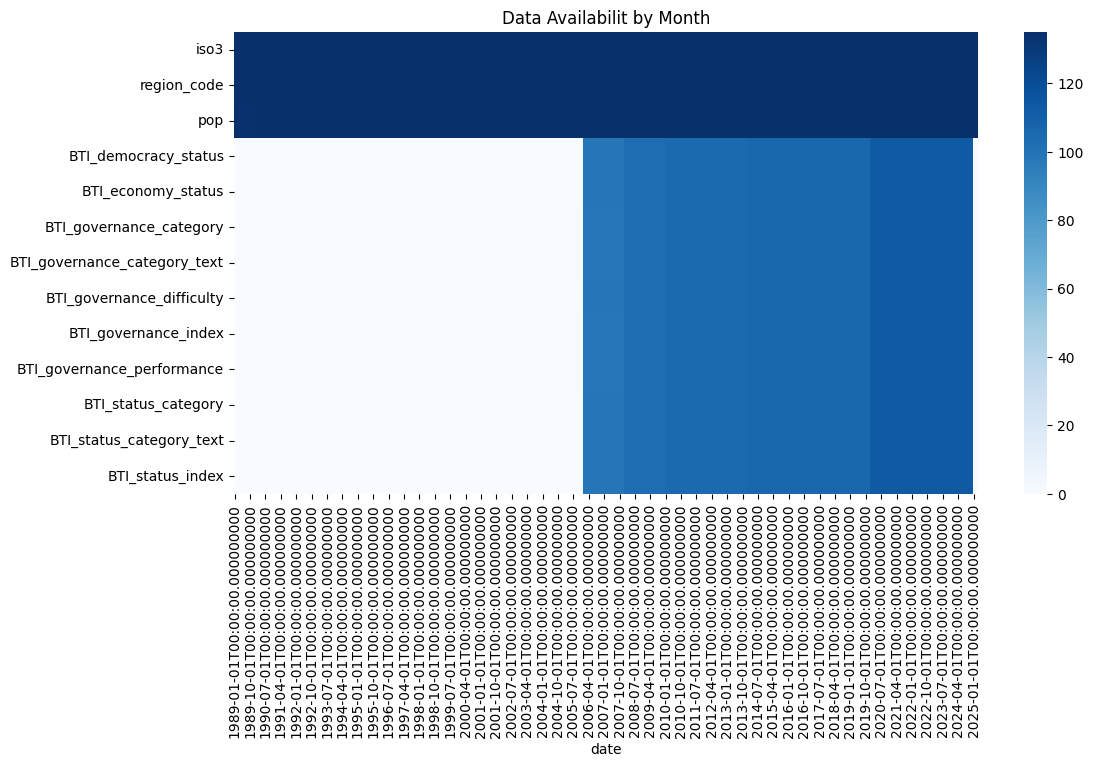

In [7]:
missing_by_month = df.groupby('date').count()
plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_month.astype(float).T, cmap='Blues')
plt.title('Data Availabilit by Month')
plt.show()

### Sample data features

In [8]:
df.tail().T

date,2025-03-01,2025-03-01,2025-03-01,2025-03-01,2025-03-01
iso3,BLZ,TUV,ZMB,TUN,ZWE
region_code,LAC,EAP,SSA,MNA,SSA
pop,411106.0,9816.0,20723965.0,12200431.0,16340822.0
BTI_democracy_status,<NA>,<NA>,<NA>,<NA>,<NA>
BTI_economy_status,<NA>,<NA>,<NA>,<NA>,<NA>
BTI_governance_category,<NA>,<NA>,<NA>,<NA>,<NA>
BTI_governance_category_text,<NA>,<NA>,<NA>,<NA>,<NA>
BTI_governance_difficulty,<NA>,<NA>,<NA>,<NA>,<NA>
BTI_governance_index,<NA>,<NA>,<NA>,<NA>,<NA>
BTI_governance_performance,<NA>,<NA>,<NA>,<NA>,<NA>


### Data structure, data types, and non-null counts

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58725 entries, 1989-01-01 to 2025-03-01
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   iso3                          58725 non-null  string 
 1   region_code                   58725 non-null  string 
 2   pop                           58713 non-null  Float64
 3   BTI_democracy_status          24300 non-null  Float64
 4   BTI_economy_status            24300 non-null  Float64
 5   BTI_governance_category       24276 non-null  Int64  
 6   BTI_governance_category_text  24276 non-null  string 
 7   BTI_governance_difficulty     24300 non-null  Float64
 8   BTI_governance_index          24276 non-null  Float64
 9   BTI_governance_performance    24276 non-null  Float64
 10  BTI_status_category           24300 non-null  Int64  
 11  BTI_status_category_text      24300 non-null  string 
 12  BTI_status_index              24300 non-nul

### Descriptive statistics of categorical columns

In [10]:
df.describe(include='string').T

,count,unique,top,freq
iso3,58725,135,AFG,435
region_code,58725,6,SSA,20445
BTI_governance_category_text,24276,5,Moderate,9012
BTI_status_category_text,24300,5,Very limited,7956


### Descriptive statistics of numerical columns

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pop,58713.0,41259533.486332,153319719.021372,8662.0,2108617.0,8303151.0,25698326.0,1438069596.0
BTI_democracy_status,24300.0,5.265556,1.816318,1.266667,3.7,5.3,6.7,9.5
BTI_economy_status,24300.0,5.025926,1.470536,1.142857,4.107143,5.107143,6.071429,8.321429
BTI_governance_category,24276.0,3.255561,1.019572,1.0,2.0,3.0,4.0,5.0
BTI_governance_difficulty,24300.0,5.984733,1.582432,1.9375,4.791667,5.875,7.145833,9.770833
BTI_governance_index,24276.0,4.583007,1.371199,1.036875,3.75375,4.743009,5.597361,7.682475
BTI_governance_performance,24276.0,5.069517,1.612319,1.05,4.05,5.216667,6.233333,8.729167
BTI_status_category,24300.0,3.687901,0.966815,1.0,3.0,4.0,4.0,5.0
BTI_status_index,24300.0,5.145741,1.536888,1.222619,4.078571,5.160714,6.275,8.860714


In [12]:
# Step 1: Create missing summary
total_rows = len(df)
missing_count = df.isnull().sum()
missing_percent = (missing_count / total_rows * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage (%)': missing_percent
}).sort_values(by='Missing Percentage (%)', ascending=False)

# Step 2: Drop columns with >70% overall missing AND >20% missing in last 5 years of the data
for col in missing_df.index:
    if missing_percent[col] > 70:
        if 'date' in df.columns and pd.api.types.is_datetime64_any_dtype(df['date']):
            max_date = df['date'].max()
            five_years_ago = max_date - pd.DateOffset(years=5)
            recent_df = df[df['date'] >= five_years_ago]
            recent_missing = recent_df[col].isnull().sum()
            recent_total = recent_df[col].shape[0]
            if recent_total == 0 or (recent_missing / recent_total * 100) > 20:
                df = df.drop(columns=[col])
        else:
            df = df.drop(columns=[col])  # Drop if no date context

# Step 3: Extract clean numeric data
numeric_df = df.select_dtypes(include=['number'])
numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan)
numeric_df = numeric_df.dropna(axis=1, how='all')  # Drop all-NaN columns
numeric_df = numeric_df.dropna(axis=0, how='any')  # Drop rows with any NaN


### Details of missing values 

In [13]:
total_rows = len(df)
missing_count = df.isnull().sum()
missing_percent = (missing_count / total_rows * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing_count, 'Missing Percentage (%)': missing_percent})
missing_df = missing_df.sort_values(by='Missing Percentage (%)', ascending=False)
missing_df

,Missing Count,Missing Percentage (%)
BTI_governance_category,34449,58.66
BTI_governance_performance,34449,58.66
BTI_governance_index,34449,58.66
BTI_governance_category_text,34449,58.66
BTI_economy_status,34425,58.62
BTI_governance_difficulty,34425,58.62
BTI_status_category,34425,58.62
BTI_status_category_text,34425,58.62
BTI_democracy_status,34425,58.62
BTI_status_index,34425,58.62


In [14]:
columns = missing_df[missing_df['Missing Percentage (%)'] < 70].index
df = df[columns]

numeric_df = df.select_dtypes(include=['number']).dropna()


In [15]:
missing_by_iso3 = df.groupby('iso3').count()
missing_by_month = df.groupby('date').count()

### Availability of data by country

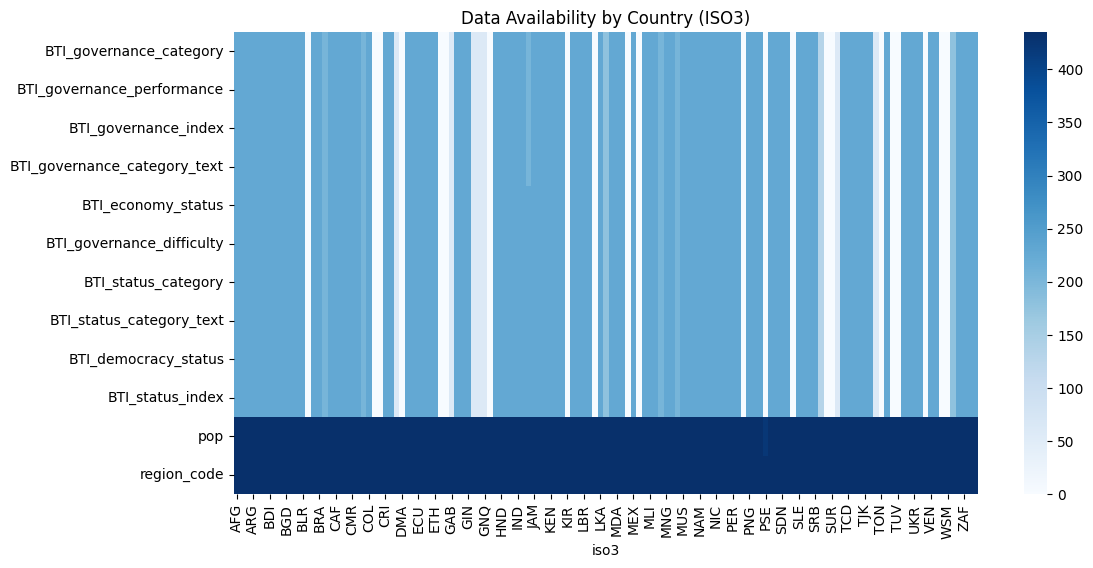

In [16]:
plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_iso3.astype(float).T, cmap='Blues')
plt.title('Data Availability by Country (ISO3)')
plt.show()

### Availbility of data by month

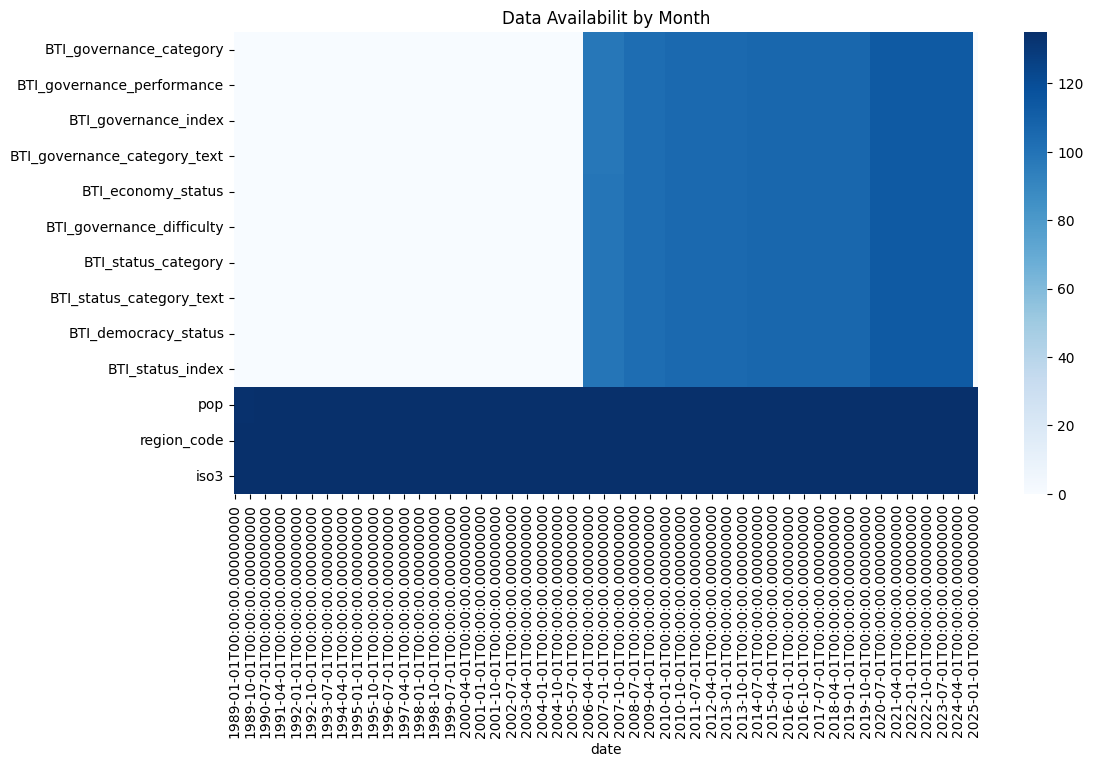

In [17]:
plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_month.astype(float).T, cmap='Blues')
plt.title('Data Availabilit by Month')
plt.show()

In [18]:
#Correlation Matrix
correlation_matrix_df = numeric_df.corr(method='pearson')

## Correlation between features

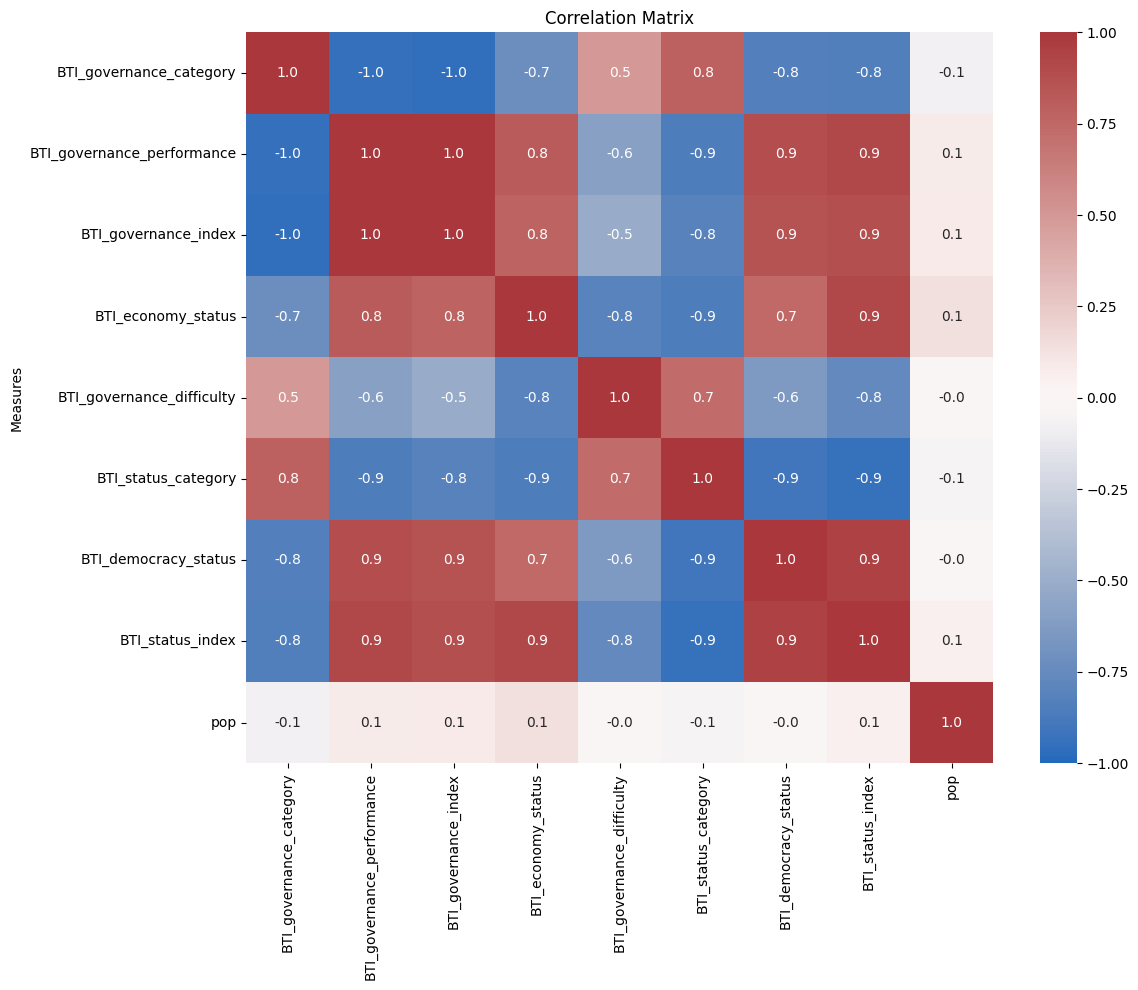

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_df, cmap='vlag', vmin=-1, vmax=1, annot=True, fmt=".1f")
plt.title('Correlation Matrix')
plt.ylabel('Measures')
plt.tight_layout()
plt.show()

### Principal Components Analysis of the features

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)
pca = PCA(n_components=0.75)
X_pca = pca.fit_transform(X_scaled)
n_components = X_pca.shape[1]
print(f"Number of components retained: {n_components}")
columns = [f'PC{i+1}' for i in range(n_components)]
print(f"Column names for PCA components: {columns}")

Number of components retained: 2
Column names for PCA components: ['PC1', 'PC2']


In [21]:
pca_df = pd.DataFrame(X_pca, index=numeric_df.index, columns=columns)

In [22]:
pca_correlation_matrix_df = pca_df.corr(method='pearson')

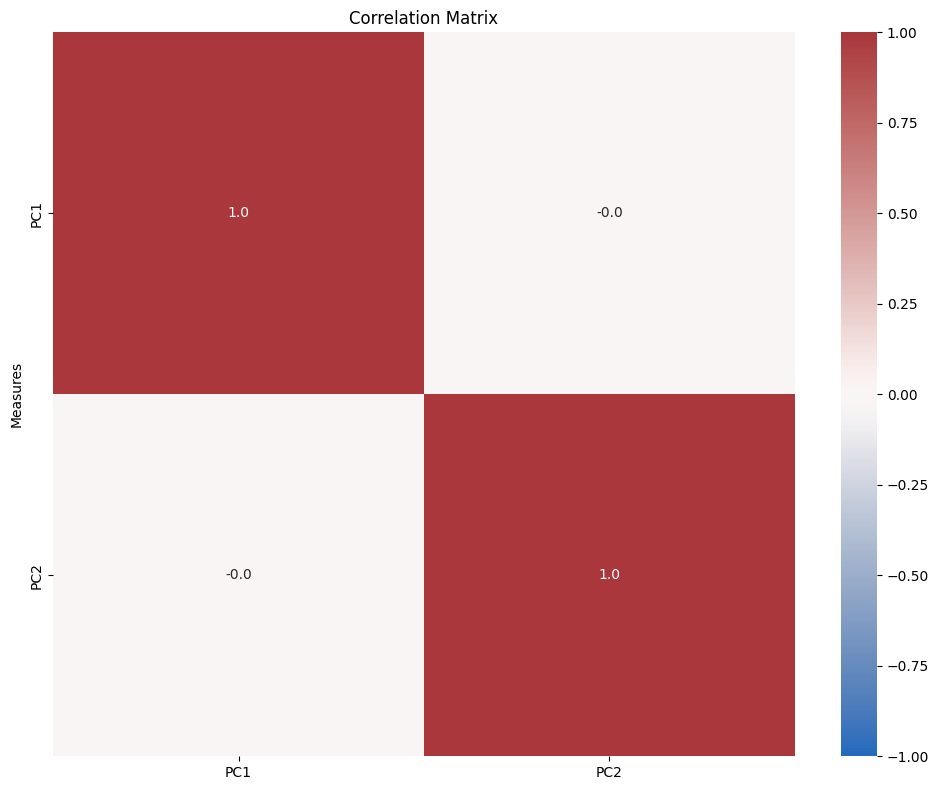

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(pca_correlation_matrix_df, cmap='vlag', vmin=-1, vmax=1, annot=True, fmt=".1f")
plt.title('Correlation Matrix')
plt.ylabel('Measures')
plt.tight_layout()
plt.show()

In [30]:
# Extract upper triangle of correlation matrix without the diagonal
corr_matrix = correlation_matrix_df.copy()
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
filtered_corr = corr_matrix.where(mask)

# Stack and filter for |correlation| > 0.5
tidy_corr = (
    filtered_corr.stack()
    .reset_index()
    .rename(columns={'level_0': 'Variable 1', 'level_1': 'Variable 2', 0: 'Correlation'})
)
tidy_corr = tidy_corr[(tidy_corr['Correlation'] > 0.5) | (tidy_corr['Correlation'] < -0.5)]
if not tidy_corr.empty:
    tidy_corr.to_excel("ACAPS_correlations_filtered.xlsx", index=False)
    print("✅ Correlation pairs saved to ACAPS_correlations_filtered.xlsx")
else:
    print("⚠️ No correlation pairs above 0.5 or below -0.5 were found.")

# Add source column
source='BTI'
tidy_corr.insert(0, 'Source', source)

# Save to Excel
tidy_corr.to_excel(f"{source}_correlations_filtered.xlsx", index=False)

print(f"✅ Correlation pairs saved to {source}_correlations_filtered.xlsx")





✅ Correlation pairs saved to ACAPS_correlations_filtered.xlsx
✅ Correlation pairs saved to BTI_correlations_filtered.xlsx


### Explained Variance by Principal Component

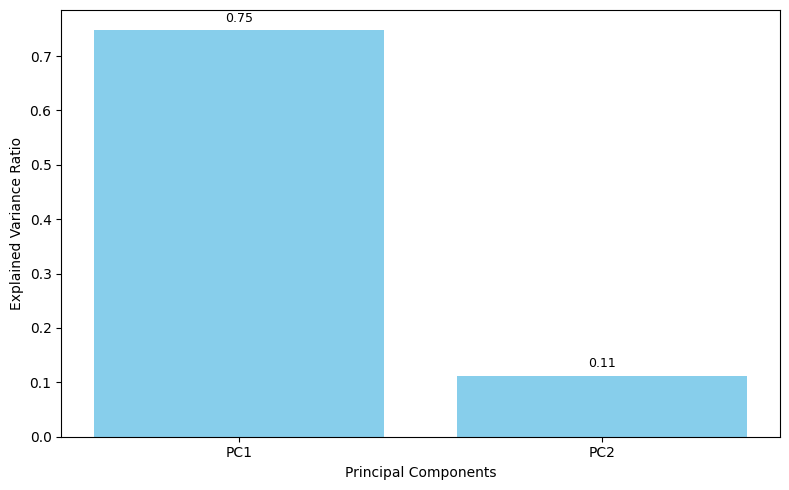

In [25]:
# Get explained variance ratios
explained_variance = pca.explained_variance_ratio_
components = np.arange(1, len(explained_variance) + 1)
labels = [f'PC{i}' for i in components]

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(x=components, height=explained_variance, tick_label=labels, color='skyblue')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=9)

plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
# plt.title('Explained Variance by Principal Component')
plt.tight_layout()
plt.show()

### Cumulative Explained Variance

Cumulative explained variance at component 2: 0.8597


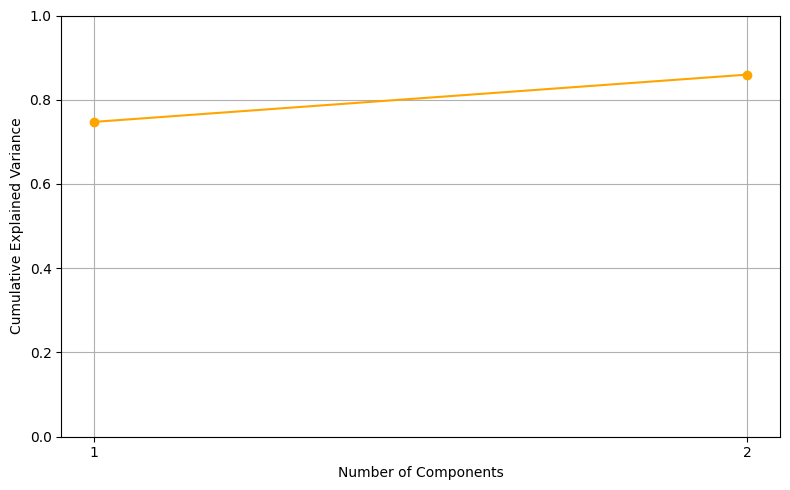

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `pca` has already been fitted
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Specify the component number (e.g., n = 4)
n = 2  # Change this to your desired component index
if n <= len(cumulative_variance):
    print(f"Cumulative explained variance at component {n}: {cumulative_variance[n-1]:.4f}")
else:
    print(f"Component {n} exceeds the total number of components ({len(cumulative_variance)}).")

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='orange')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(1, len(cumulative_variance) + 1, step=1))
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
feature_names = numeric_df.columns
components = pca.components_
loadings_df = pd.DataFrame(components.T, index=feature_names, columns=[f'PC{i+1}' for i in range(components.shape[0])])

## PCA Loadings Heatmap

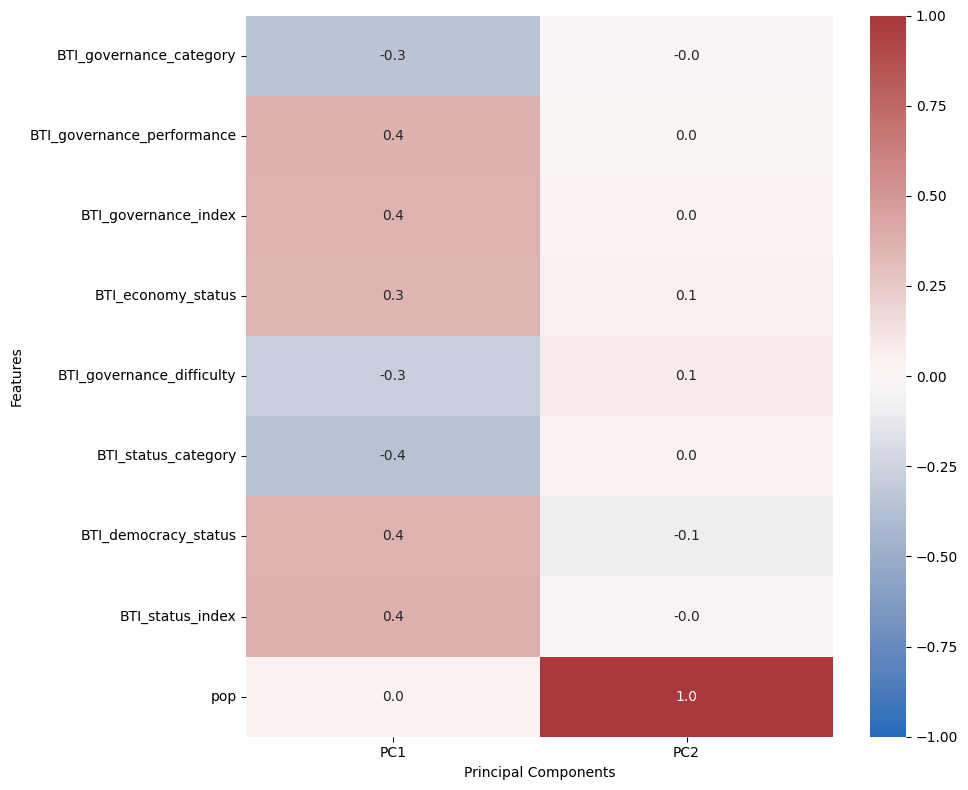

In [28]:
# create heatmap from loadings_df using sns
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, cmap='vlag', vmin=-1, vmax=1, annot=True, fmt=".1f")
# plt.title('PCA Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [29]:
# Round for readability
print(loadings_df.round(2))



                             PC1   PC2
BTI_governance_category    -0.35 -0.02
BTI_governance_performance  0.37  0.02
BTI_governance_index        0.36  0.04
BTI_economy_status          0.35  0.06
BTI_governance_difficulty  -0.29  0.08
BTI_status_category        -0.36  0.04
BTI_democracy_status        0.36 -0.09
BTI_status_index            0.38 -0.03
pop                         0.03  0.99


### Physical Interpretation
### PC1- "Governance & Democracy Strength Index" PC1 represents a composite measure of governance quality and democratic institutional strength.High values correspond to effective governance, better economic status, democratic stability, and lower governance difficulty. Negative values may reflect fragile states with weak governance structures.
